In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import feature.random_graph_dataset as random_graph_dataset
import feature.graph_conversions as graph_conversions
import model.discrete_diffusers as discrete_diffusers
import model.gnn as gnn
import model.util as model_util
import model.generate as generate
import torch
import torch_geometric
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm.notebook

In [2]:
out_path = "/gstore/home/tsenga5/discrete_graph_diffusion/figures/controlled_cliques"

os.makedirs(out_path, exist_ok=True)

In [3]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Create the data loader

In [4]:
# Create the data loader for training
node_dim = 1

dataset = random_graph_dataset.RandomGraphDataset(
    node_dim, num_items=6400,
    graph_type="diverse_cliques", clique_sizes=[3, 4, 5, 6], noise_level=0, unity_features=True
)
data_loader = torch_geometric.loader.DataLoader(
    dataset, batch_size=32, shuffle=True, num_workers=0  # TODO: allow multi-processing
)

### Import the model

In [5]:
# Create the diffuser and model
diffuser = discrete_diffusers.BernoulliOneSkipDiffuser(100, 10, (1,))  # Make input shape just 1
t_limit = 1000

base_path = "/gstore/data/resbioai/tsenga5/discrete_graph_diffusion/models/trained_models"
model_path = os.path.join(base_path, "cliques_edge-addition", "3", "epoch_100_ckpt.pth")

model = model_util.load_model(gnn.GraphLinkGAT, model_path).to(DEVICE)

### Generate graphs without control

In [6]:
def sample_prior():
    """
    Samples from the prior distribution. Returns a batch as a Data object.
    """
    data = next(iter(data_loader))
    edges = graph_conversions.pyg_data_to_edge_vector(data)
    sampled_edges = diffuser.sample_prior(
        edges.shape[0], # Samples will be E x 1
        torch.tile(torch.tensor([t_limit], device=DEVICE), edges.shape)
    )[:, 0]  # Shape: E
    data.edge_index = graph_conversions.edge_vector_to_pyg_data(data, sampled_edges)
    return data

In [7]:
# Take the trained model and go backwards to sample some graphs
print("Sampling some reverse trajectories")
prior = sample_prior()
samples_no_cont = generate.generate_graph_samples(
    model, diffuser, prior, t_limit=t_limit, verbose=True
)

# Split samples into individual graphs
graph_samps_no_cont = graph_conversions.split_pyg_data_to_nx_graphs(samples_no_cont)

/gstore/home/tsenga5/miniconda3/envs/graph-diff/lib/python3.8/site-packages/torch_geometric/utils/convert.py:192: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  data[key] = torch.tensor(value)


Sampling some reverse trajectories


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:47<00:00,  9.28it/s]


0


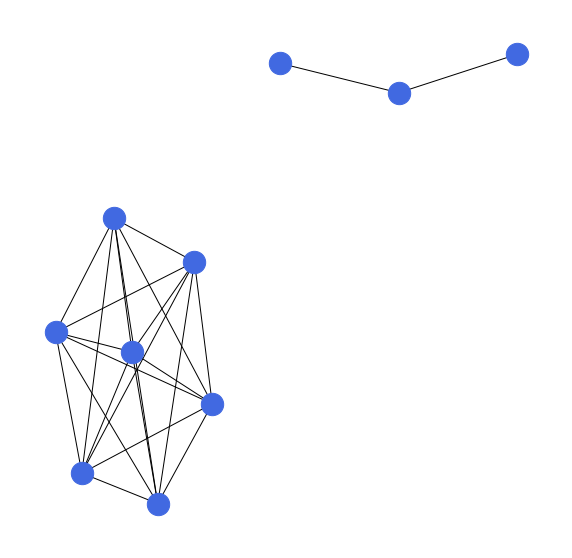

1


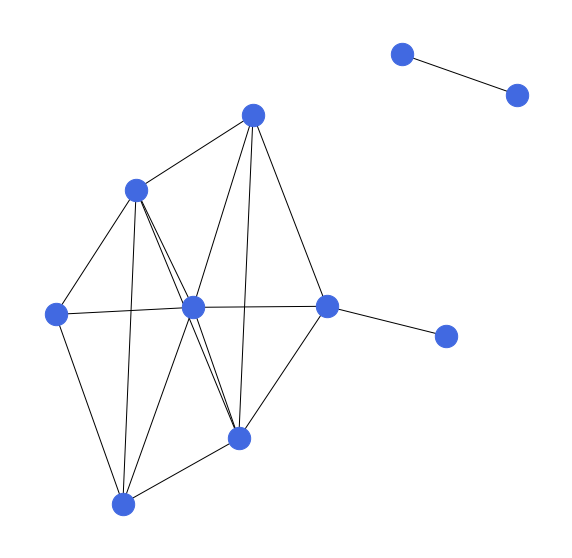

2


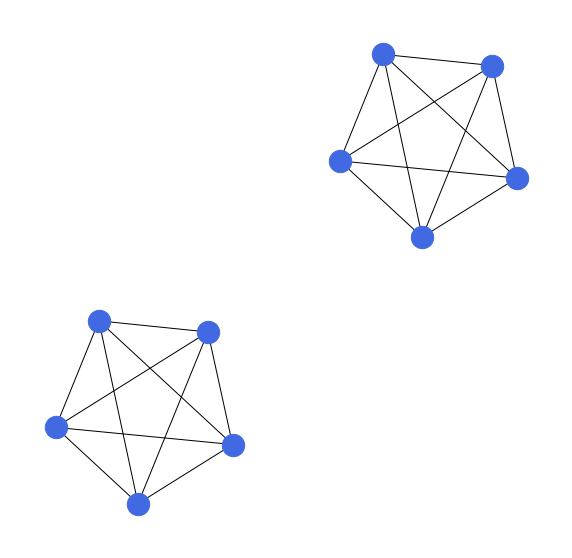

3


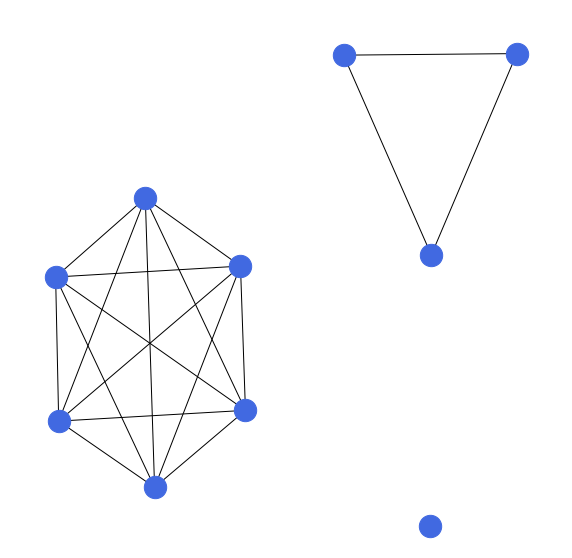

4


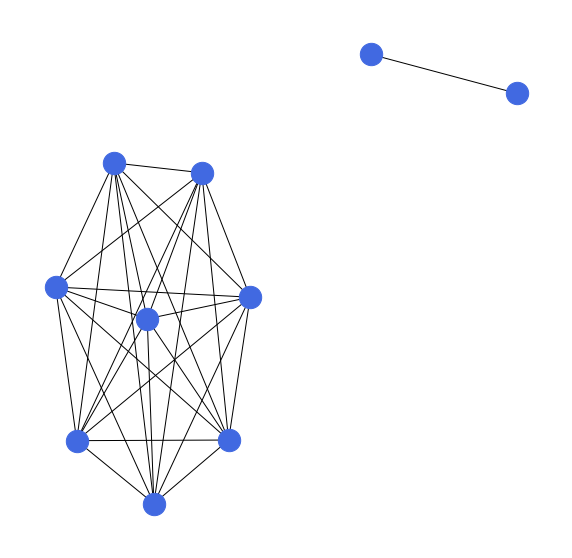

5


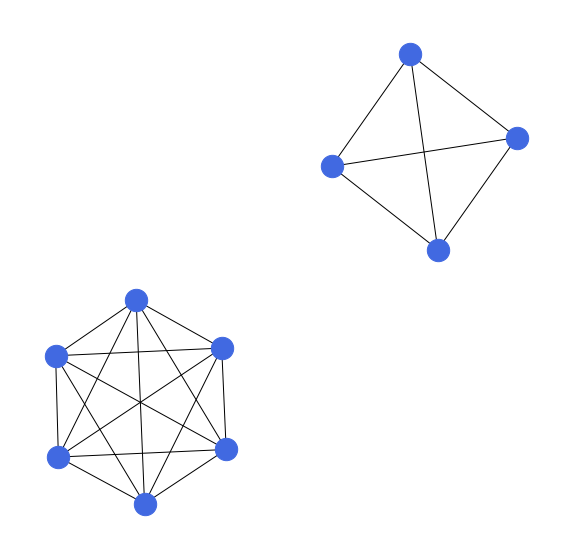

6


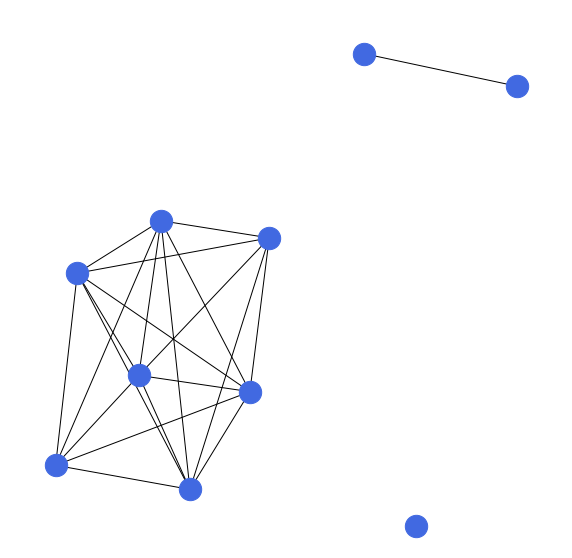

7


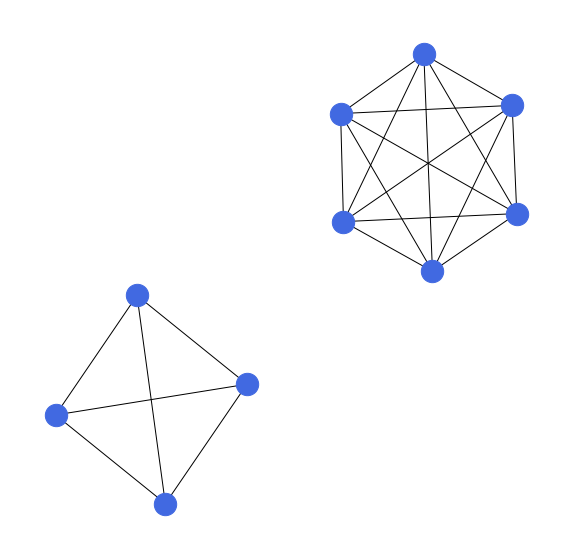

8


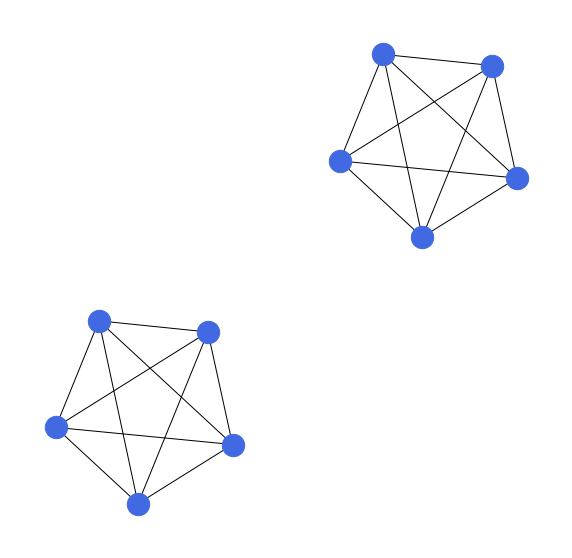

9


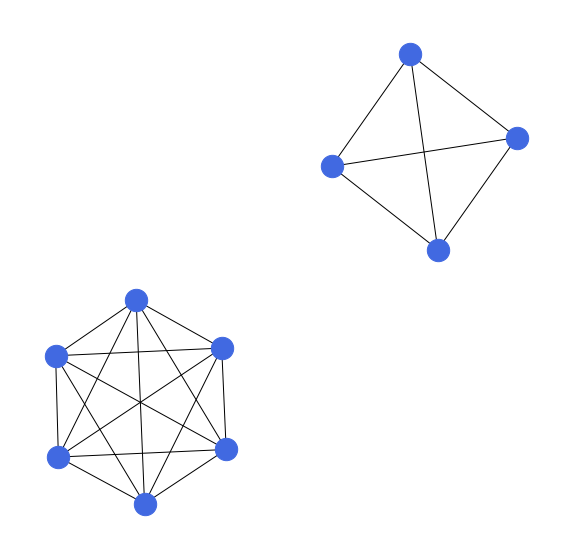

10


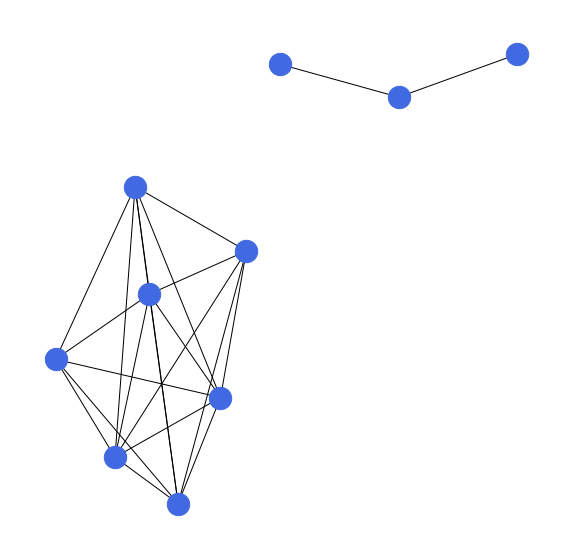

11


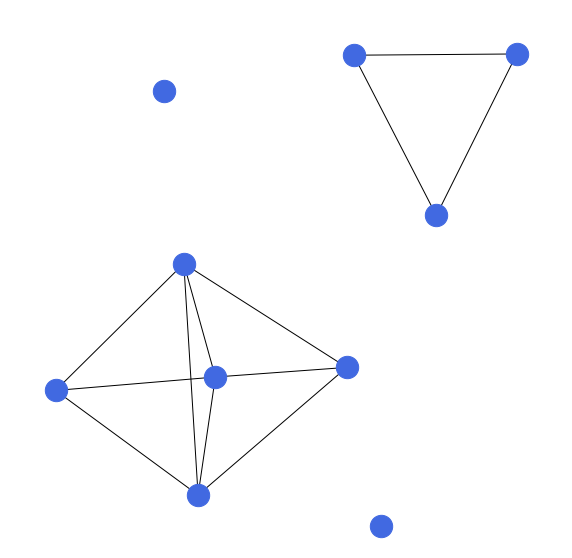

12


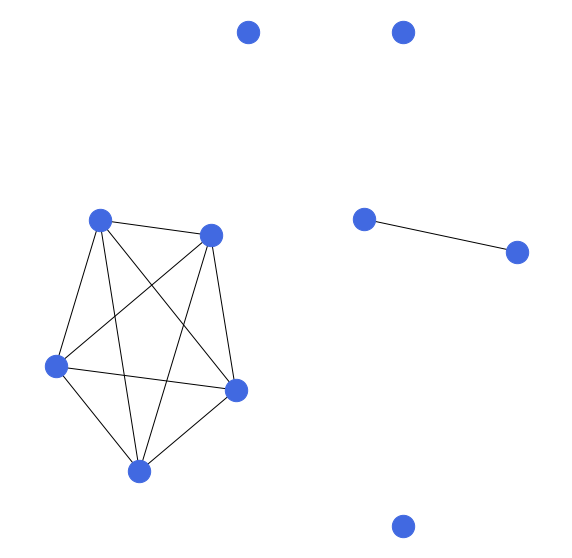

13


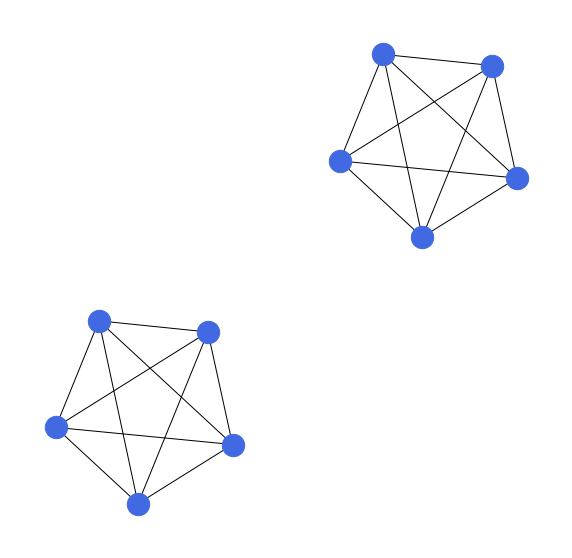

14


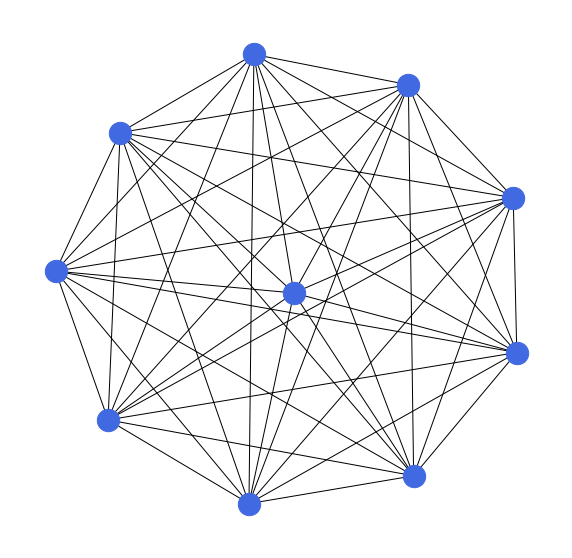

15


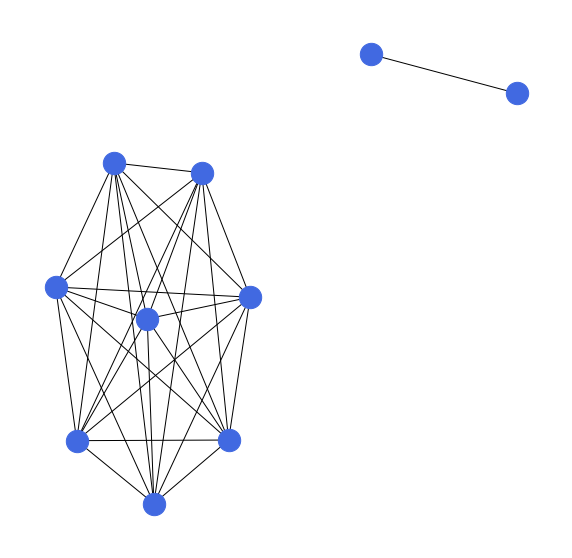

16


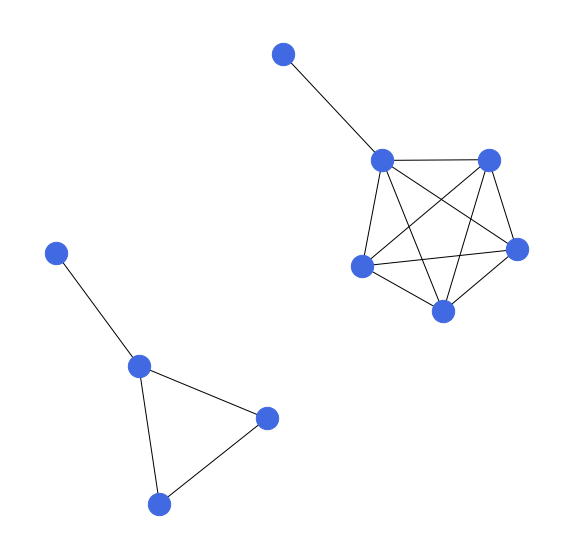

17


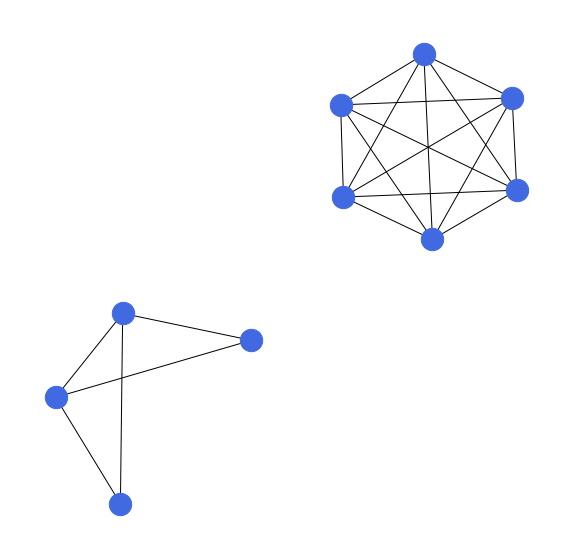

18


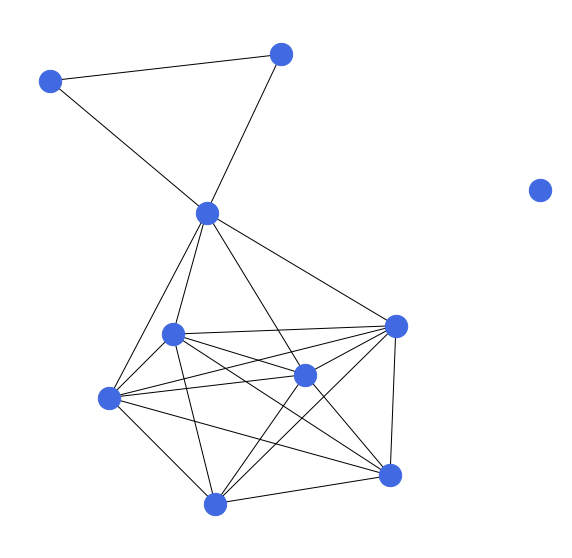

19


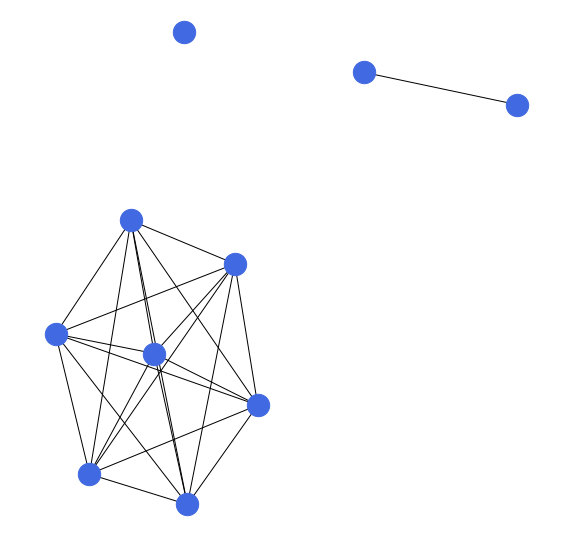

20


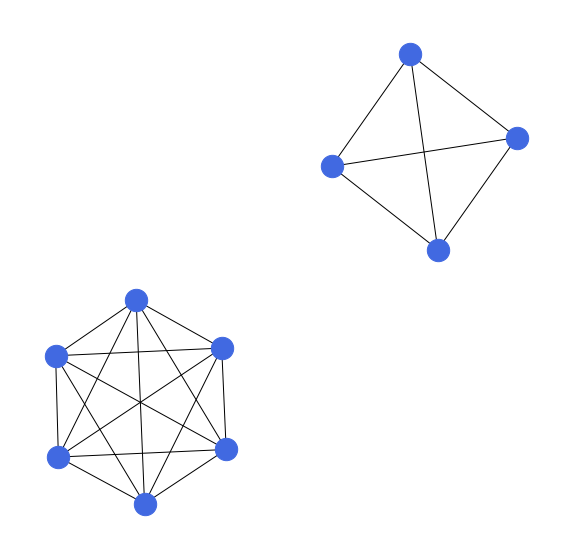

21


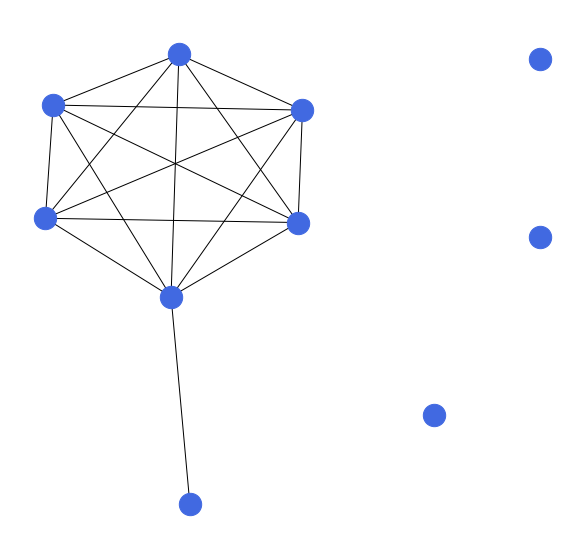

22


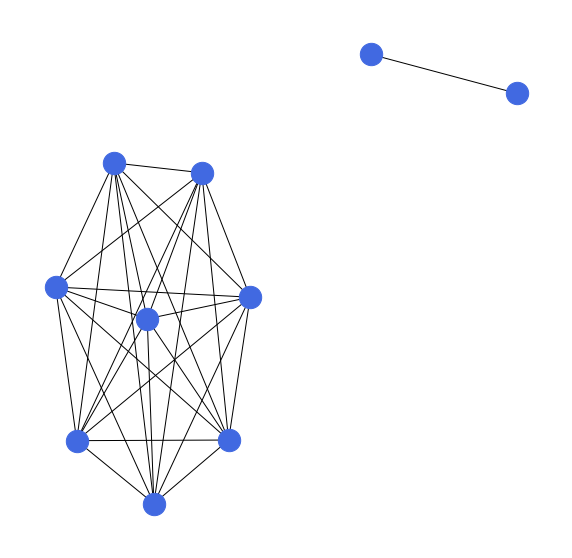

23


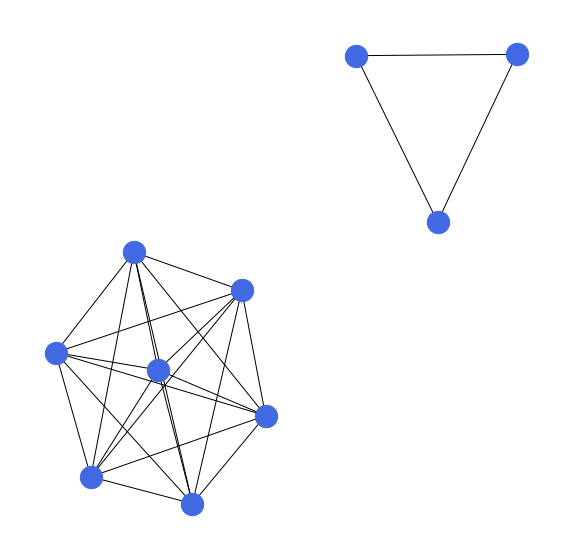

24


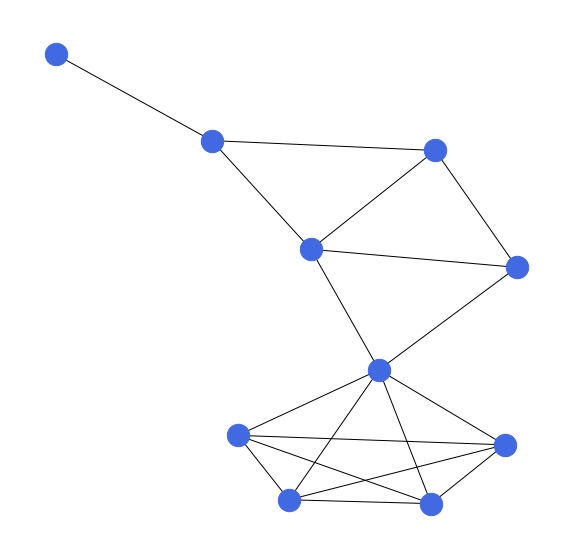

25


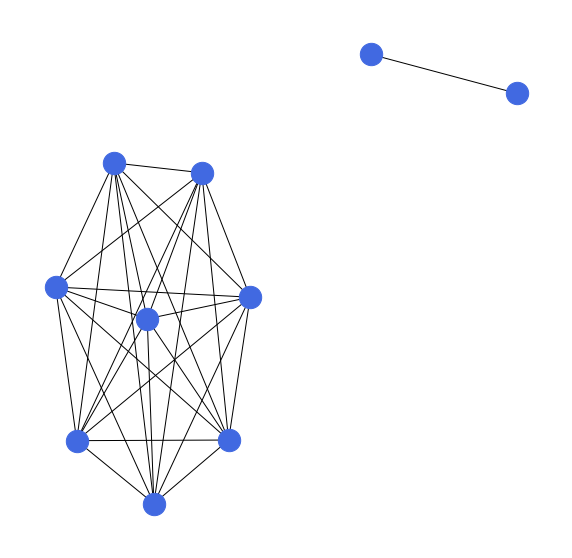

26


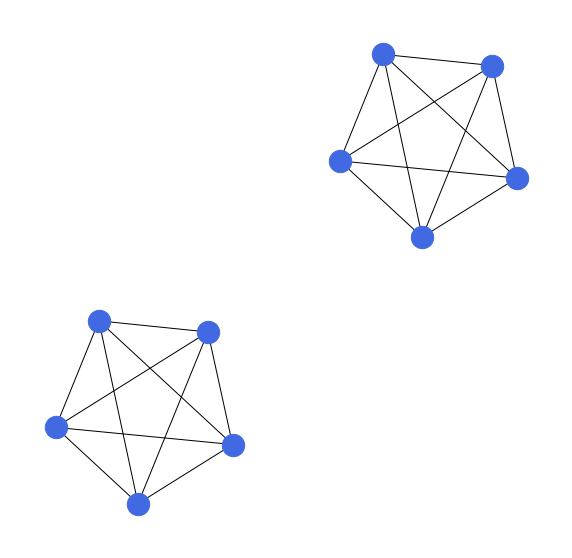

27


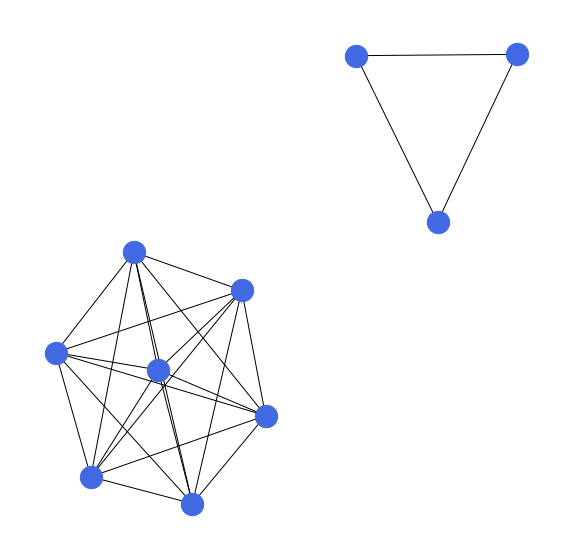

28


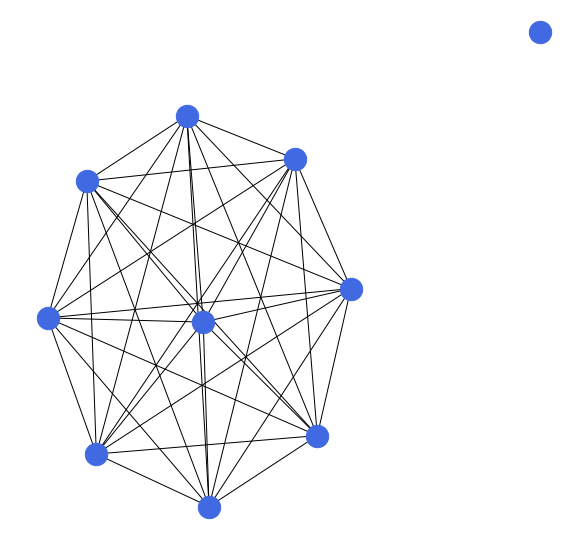

29


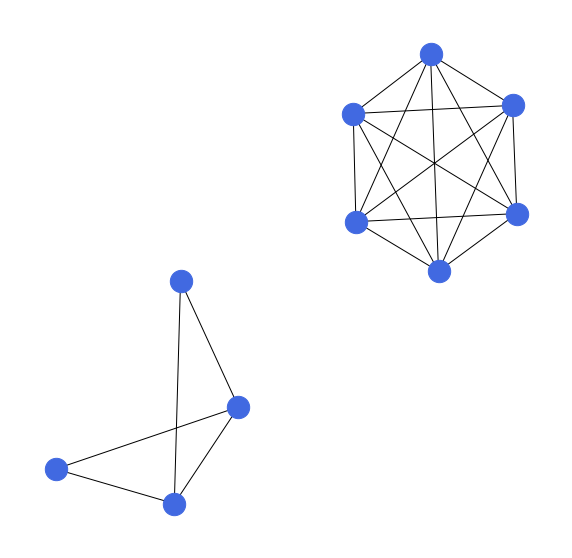

30


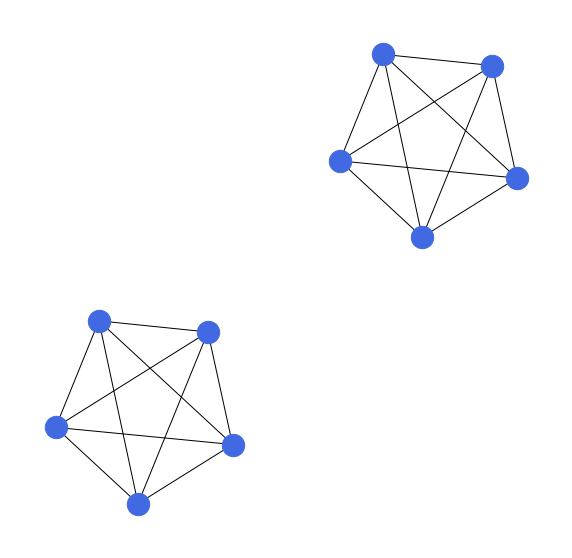

31


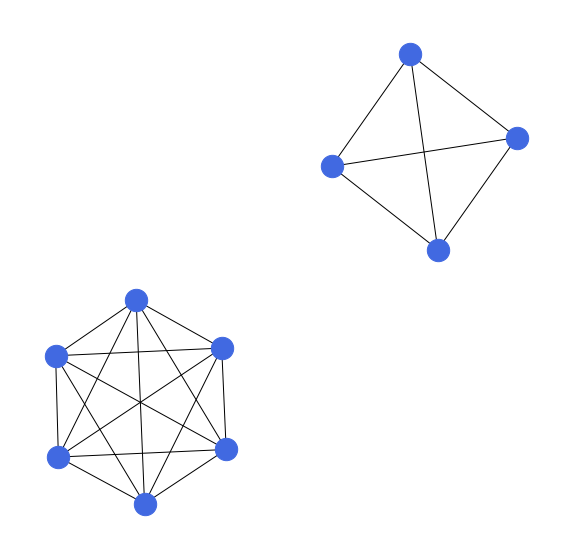

In [8]:
# Plot some randomly generated graphs
for i, g in enumerate(graph_samps_no_cont):
    print(i)
    fig, ax = plt.subplots(figsize=(10, 10))
    nx.draw(g, pos=nx.nx_pydot.graphviz_layout(g), ax=ax, node_size=500, node_color="royalblue")
    fig.savefig(
        os.path.join(out_path, "no_cont_%d.svg" % i),
        format="svg"
    )
    plt.show()

In [9]:
# Count graphs with 6-cliques
num_with_6 = sum(any(len(c) >= 6 for c in nx.find_cliques(g)) for g in graph_samps_no_cont)
print("%d/%d (%.2f%%)" % (num_with_6, len(graph_samps_no_cont), num_with_6 / len(graph_samps_no_cont) * 100))

22/32 (68.75%)


### Generate graphs with control

In [10]:
prior = sample_prior()

# Pick a single clique to retain in each graph
# TODO: this is still rather inefficient
all_edges_inds = graph_conversions.edge_vector_to_pyg_data(prior, 1, reflect=False)
all_edges_vec = graph_conversions.pyg_data_to_edge_vector(prior)
assert all_edges_inds.shape[1] == all_edges_vec.shape[0]
retain_mask = torch.full(all_edges_vec.shape, False)
for i in range(len(prior.ptr) - 1):
    start, end = prior.ptr[i], prior.ptr[i + 1]
    
    # Arbitrarily make the first 6 a clique
    for ind_2 in range(start, start + 6):
        for ind_1 in range(start, ind_2):
            m = (all_edges_inds[0, :] == ind_1) & (all_edges_inds[1, :] == ind_2)
            assert torch.sum(m).item() == 1
            retain_mask[m] = True
            
# Go through sampling procedure
data_t = prior
for t in tqdm.notebook.trange(t_limit, 0, -1):
    data_t = generate.generate_graph_samples(
        model, diffuser, data_t, t_limit=t, t_start=(t - 1)
    )
    
    # Make sure the edges we want to exist will exist
    edges_t = graph_conversions.pyg_data_to_edge_vector(data_t)
    edges_t[retain_mask] = 1
    data_t.edge_index = graph_conversions.edge_vector_to_pyg_data(data_t, edges_t)

graph_samps_with_cont = graph_conversions.split_pyg_data_to_nx_graphs(data_t)

  0%|          | 0/1000 [00:00<?, ?it/s]

0


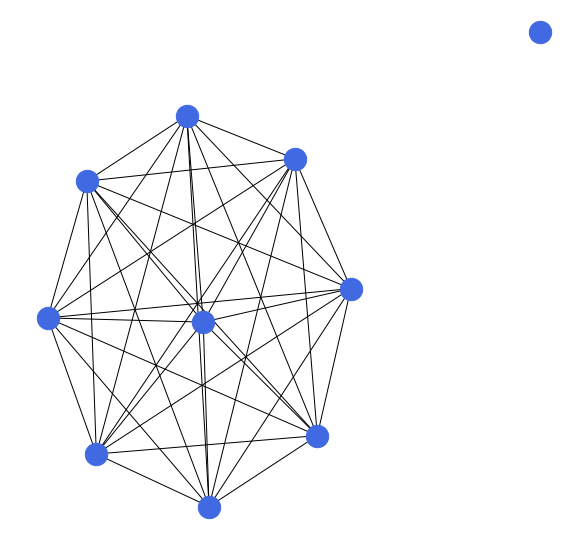

1


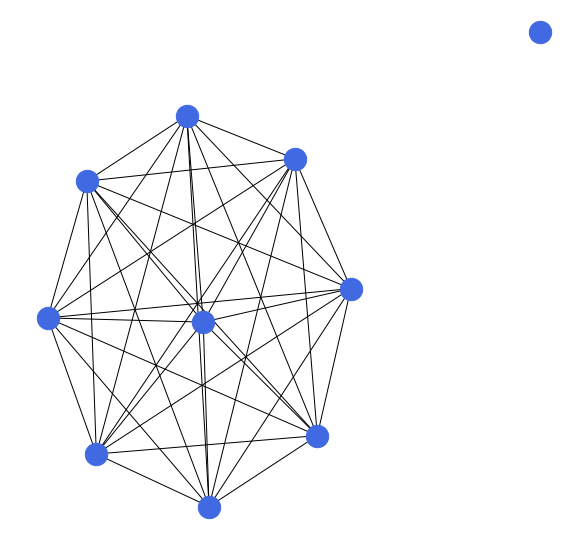

2


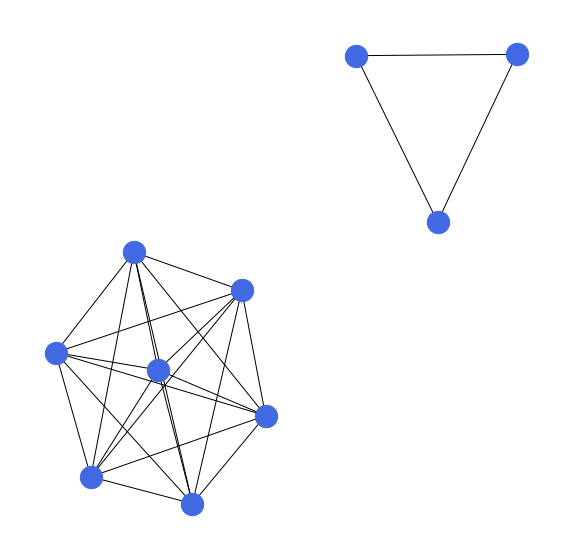

3


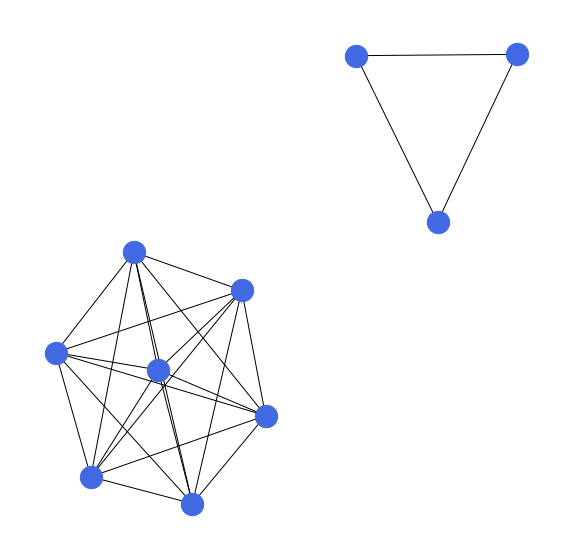

4


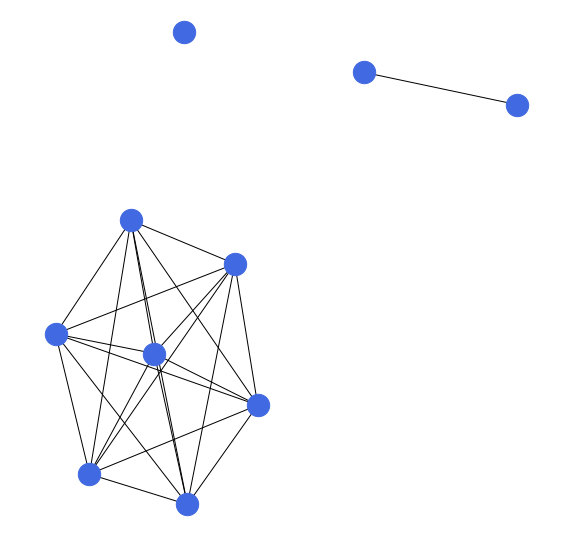

5


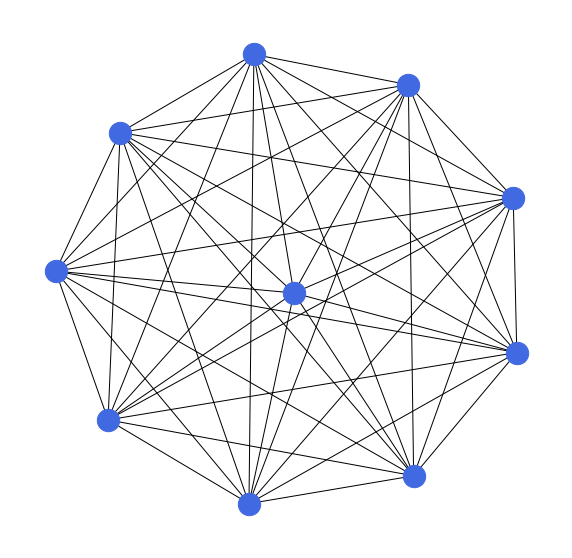

6


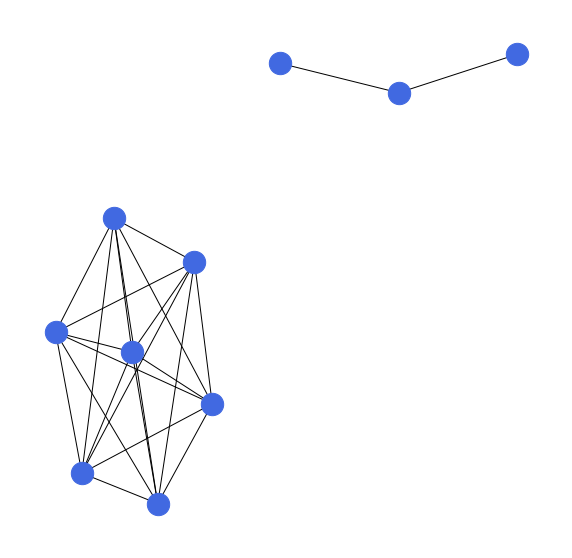

7


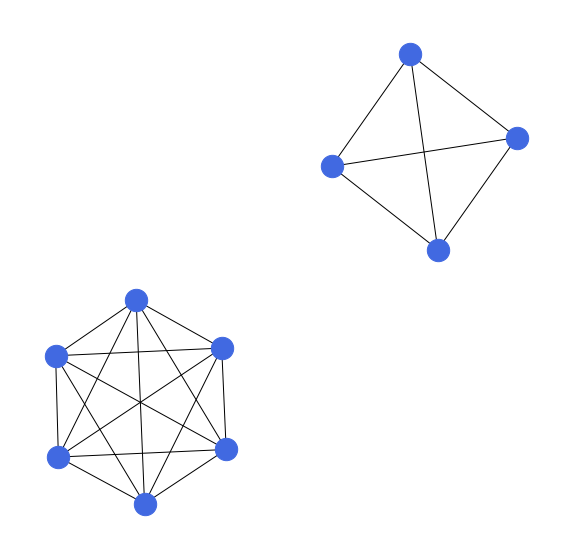

8


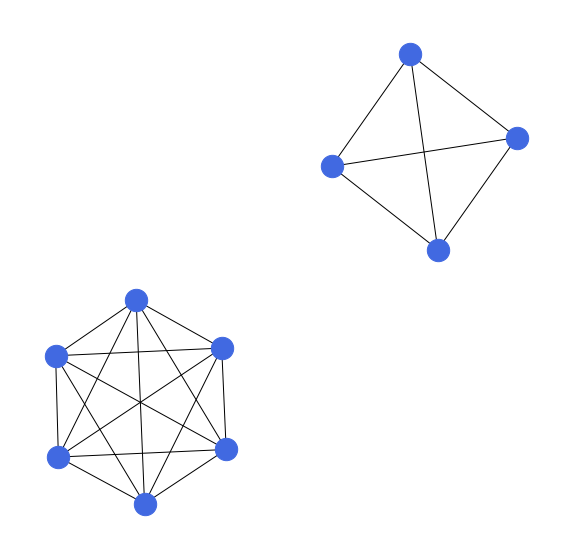

9


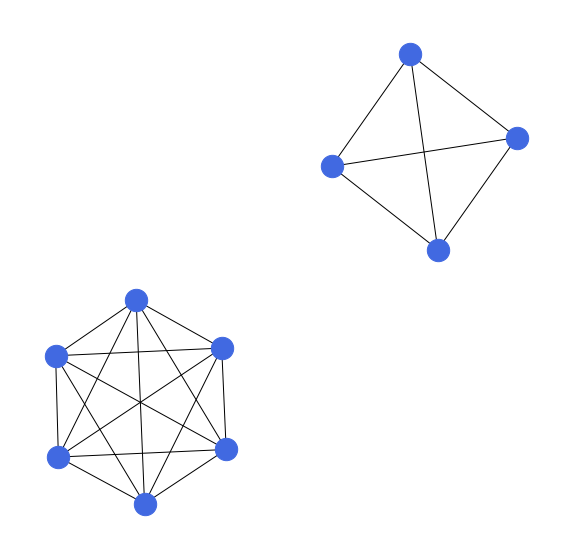

10


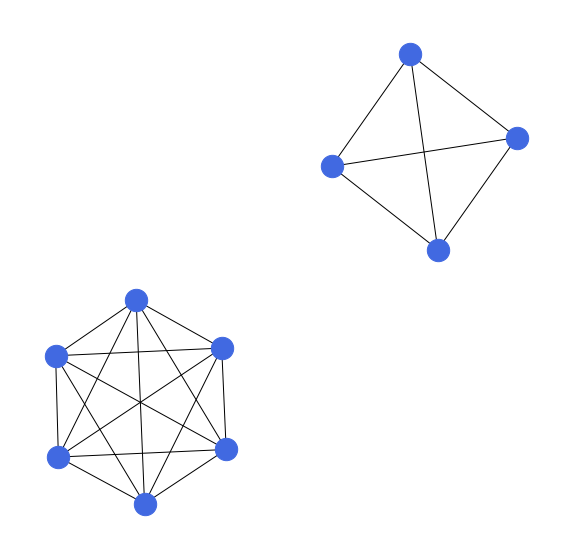

11


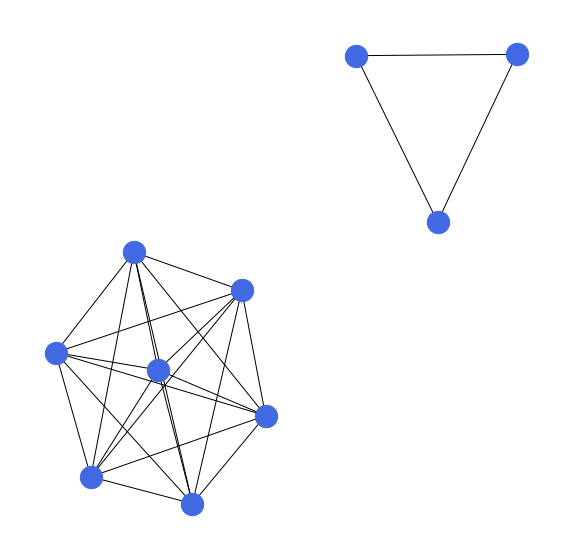

12


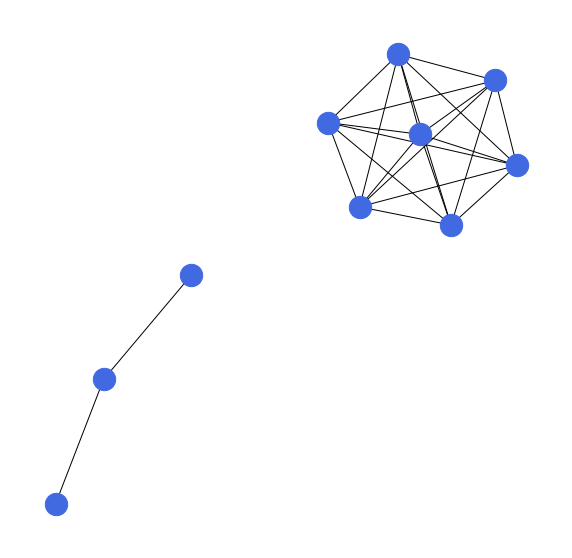

13


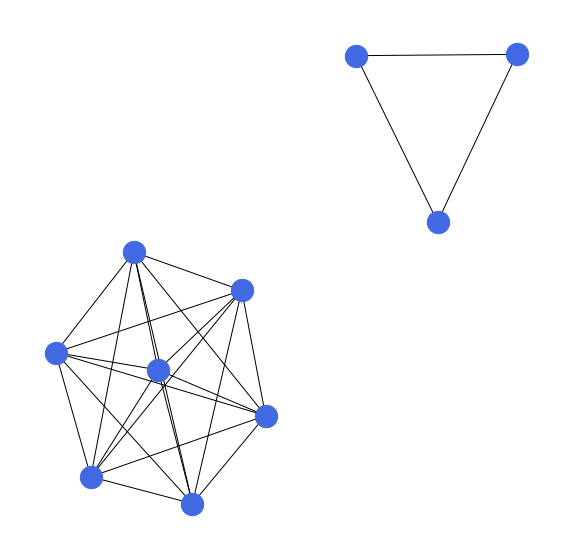

14


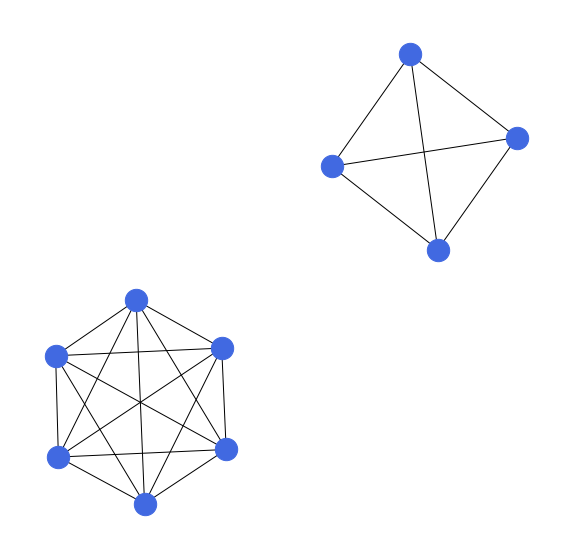

15


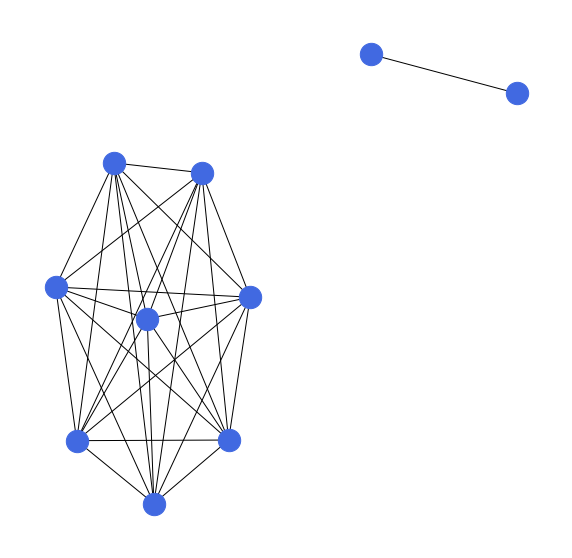

16


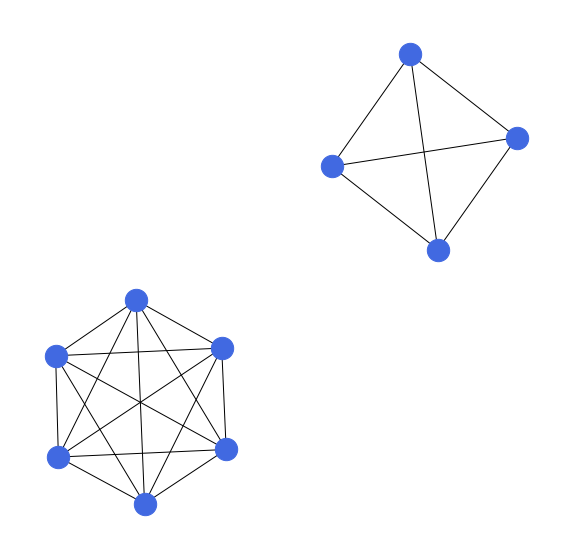

17


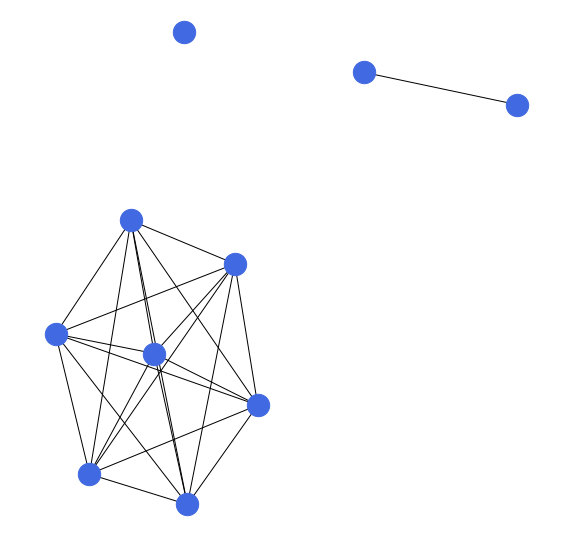

18


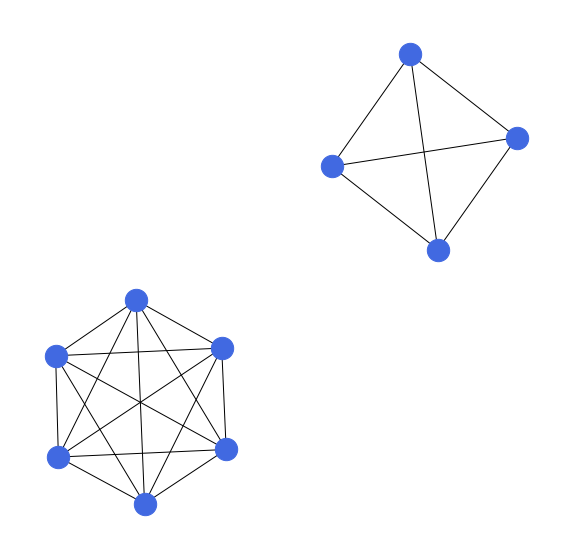

19


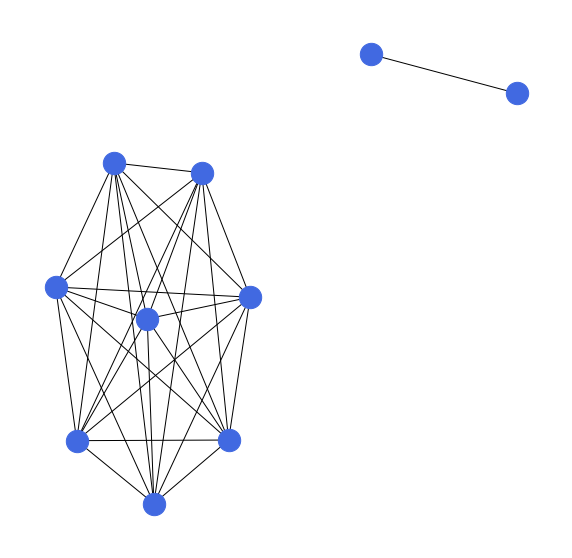

20


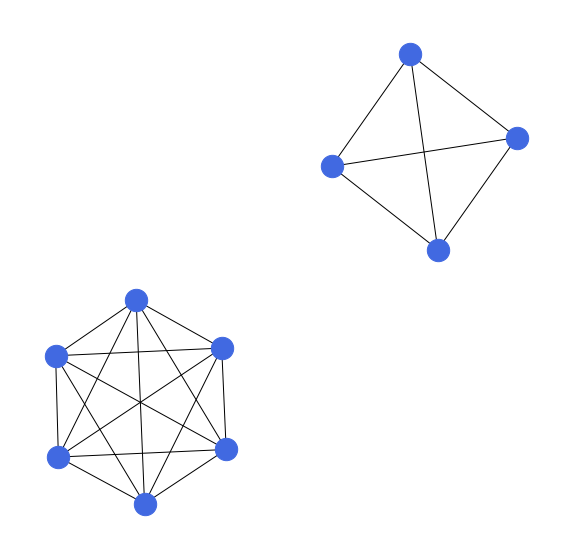

21


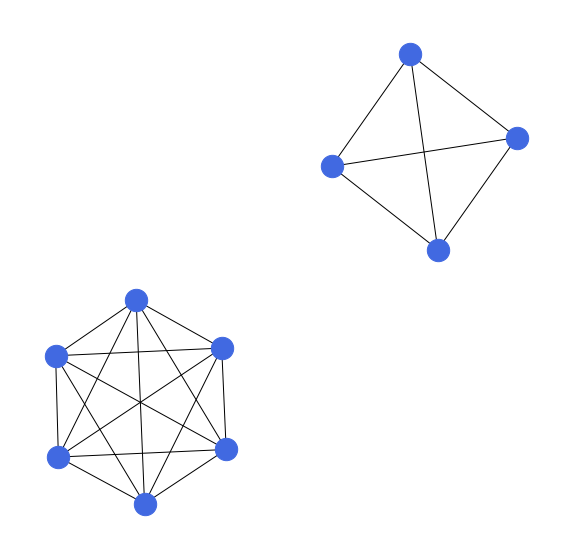

22


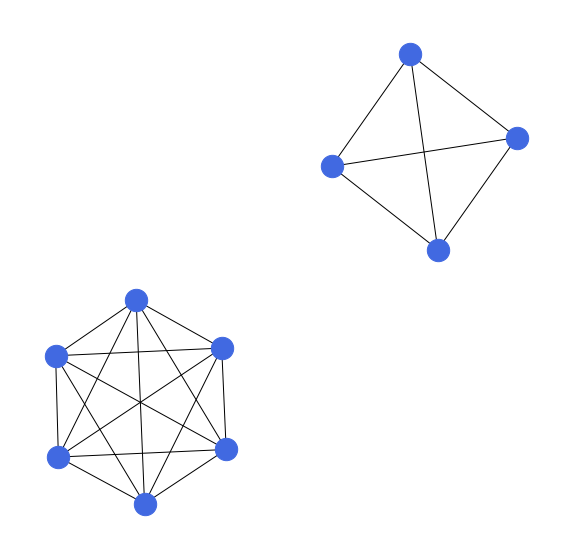

23


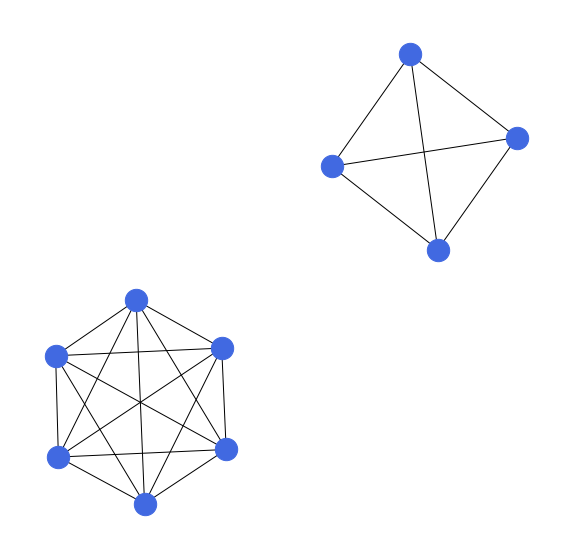

24


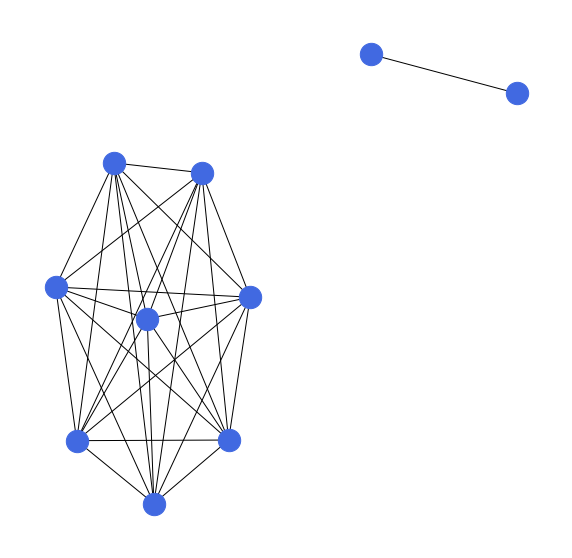

25


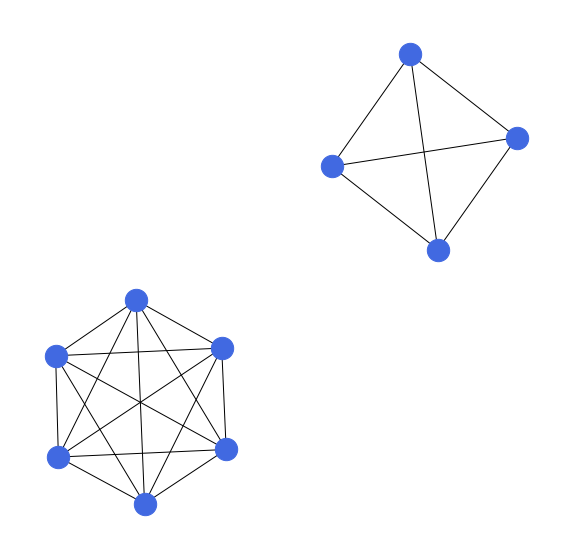

26


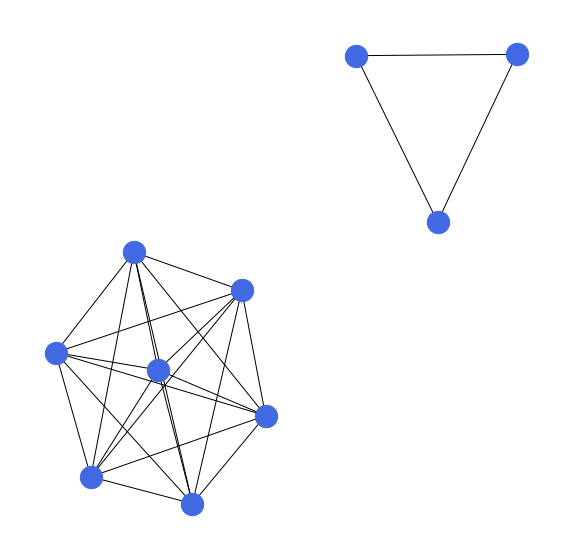

27


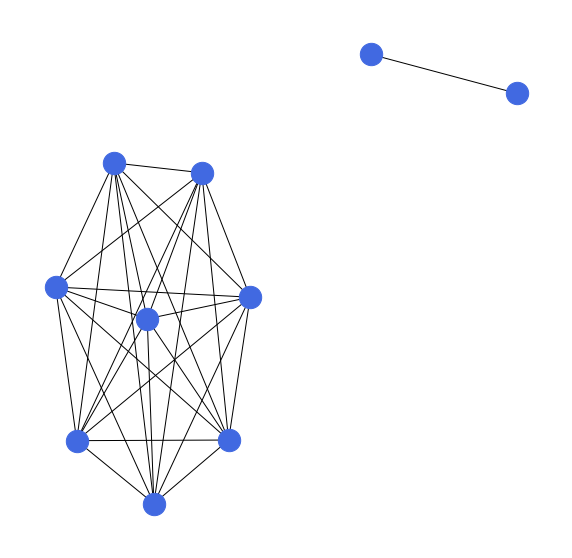

28


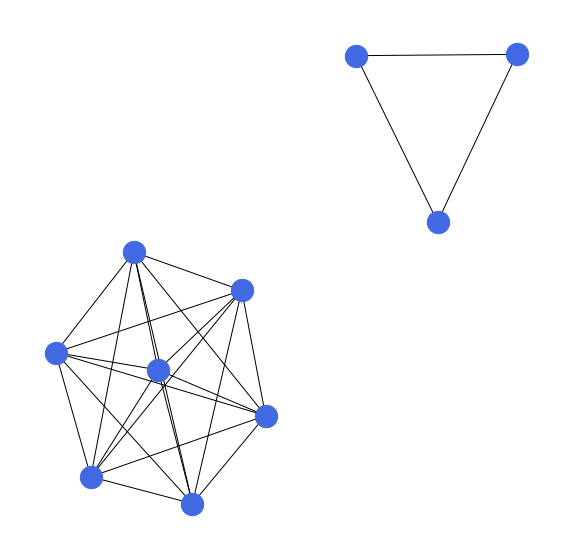

29


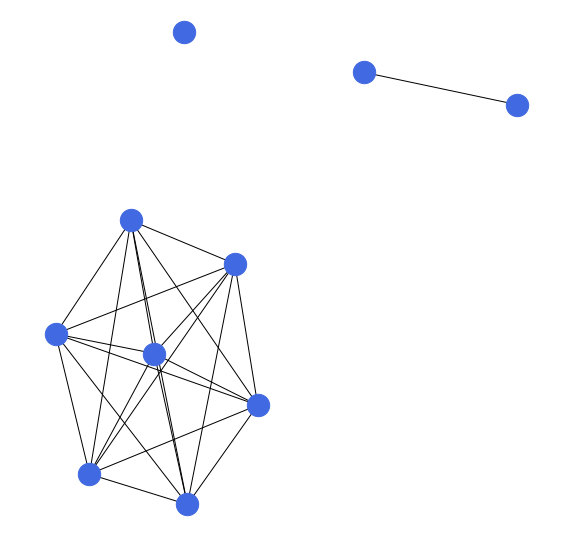

30


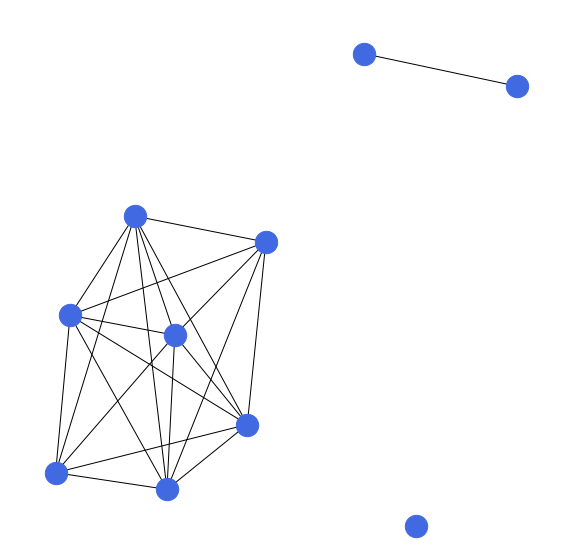

31


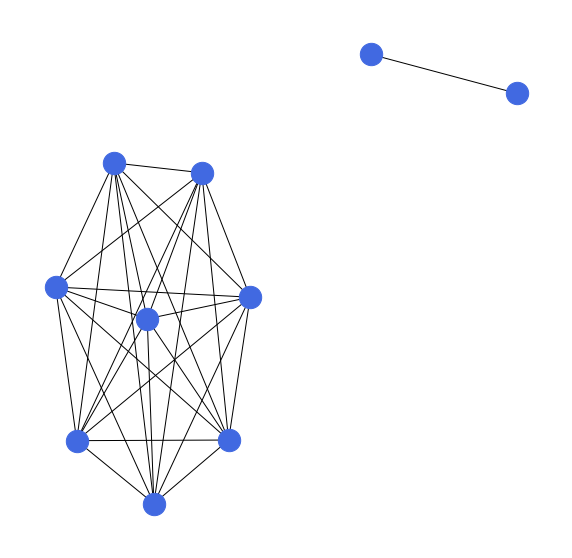

In [11]:
# Plot some randomly generated graphs
for i, g in enumerate(graph_samps_with_cont):
    print(i)
    fig, ax = plt.subplots(figsize=(10, 10))
    nx.draw(g, pos=nx.nx_pydot.graphviz_layout(g), ax=ax, node_size=500, node_color="royalblue")
    fig.savefig(
        os.path.join(out_path, "with_cont_%d.svg" % i),
        format="svg"
    )
    plt.show()

In [12]:
# Count graphs with 6-cliques
num_with_6 = sum(any(len(c) >= 6 for c in nx.find_cliques(g)) for g in graph_samps_with_cont)
print("%d/%d (%.2f%%)" % (num_with_6, len(graph_samps_with_cont), num_with_6 / len(graph_samps_with_cont) * 100))

32/32 (100.00%)
